![](cat.jpg)

# Pose Determination

Kevin J. Walchko, Phd

18 Feb 2021

[Home](../index.ipynb)

---

![](axis-angle.png)

*Note:* changed bold $\theta$ to r since the bold face font didn't show up nicely in latex.

Rodrigues' rotation formula, named after Olinde Rodrigues, is an efficient algorithm for rotating for an axis-angle ($r$) representation consisting of a vector in space, given an axis ($e$) and angle of rotation ($\theta$). By extension, this can be used to transform all three basis vectors to compute a rotation matrix in SO(3), the group of all rotation matrices, from an axis–angle representation. 

$$
r = \begin{bmatrix} r_x & r_y & r_z \end{bmatrix} = \theta e\\
\theta = norm( r ) \\
e = r / \theta \\
R = I + (sin \theta) K + (1-cos \theta) K^2 \\
K = skew(r) = \begin{bmatrix}
    0 & -r_z & r_y \\
    r_z & 0 & -r_x \\
    -r_y & r_x & 0
\end{bmatrix}
$$

In [181]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from math import atan2, asin, pi, sin, cos
from colorama import Fore, Back

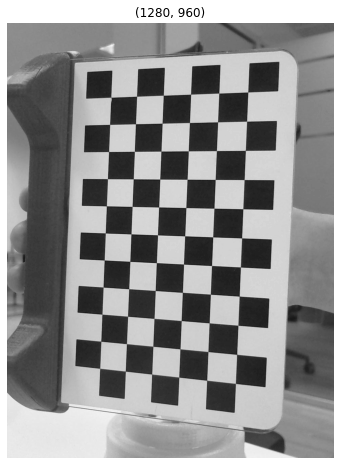

In [191]:
img = cv2.imread("frame0.jpg", 0)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray")
plt.title(f"{img.shape}")
plt.axis('off');

Chessboard found: True


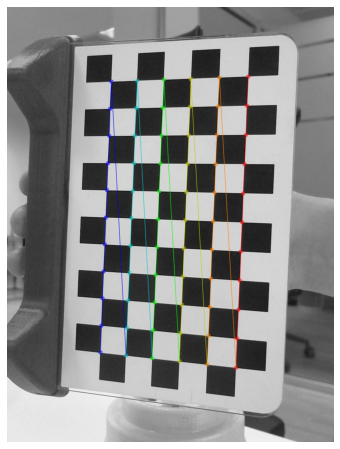

In [192]:
# Pattern parameters
rows = 6
columns = 11
square_width = 13

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(
    img, 
    (columns, rows), 
    # flags=cv2.CALIB_CB_FAST_CHECK
)

print(f"Chessboard found: {ret}")

# Draw corners into image
image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.drawChessboardCorners(image, (columns, rows), corners, ret)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.axis('off');

In [193]:
# reviewing results and seeing if calibration image is good
ret, sharp = cv2.estimateChessboardSharpness(
    img, 
    (columns, rows),
    corners
)
print("Sharpness: {:.2f}, ave min brightness: {:.2f}, ave max brightness: {}".format(*ret))

val = 0
for s in sharp:
    x,y,width,sb,sw = s
    val += width
    x,y = int(x), int(y)
    sb,sw = int(sb),int(sw)
    color = Fore.GREEN if width < 3.0 else Fore.RED
    print(f"{color}=>{Fore.RESET} Corner ({x},{y}) width: {width:.2f} signal black/white: {sb:3d}/{sw:3d}")

Sharpness: 1.80, ave min brightness: 25.91, ave max brightness: 217.0
=> Corner (706,247) width: 2.23 signal black/white:  20/211
=> Corner (621,249) width: 1.67 signal black/white:  32/215
=> Corner (538,252) width: 1.64 signal black/white:  20/218
=> Corner (458,254) width: 1.59 signal black/white:  28/221
=> Corner (380,256) width: 1.93 signal black/white:  27/214
=> Corner (702,333) width: 2.17 signal black/white:  36/224
=> Corner (617,334) width: 1.65 signal black/white:  24/217
=> Corner (535,335) width: 1.66 signal black/white:  34/217
=> Corner (454,336) width: 1.72 signal black/white:  22/218
=> Corner (377,337) width: 1.32 signal black/white:  28/225
=> Corner (699,418) width: 1.88 signal black/white:  17/214
=> Corner (614,418) width: 1.80 signal black/white:  32/212
=> Corner (531,418) width: 1.65 signal black/white:  24/225
=> Corner (451,418) width: 1.90 signal black/white:  23/220
=> Corner (373,418) width: 2.04 signal black/white:  26/218
=> Corner (695,504) width: 2.5

In [201]:
# Compute object points
objp = np.zeros((rows * columns, 3), dtype=float)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1, 2)
objp *= square_width

# Camera calibration results
cx, cy = 960//2, 1280//2
f = 1430
camera_matrix = np.array([[f, 0, cx],[0, f, cy],[0, 0, 1]], dtype=float)
distortion_coefficients = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)

# Compute pose
ret, rvecs, tvecs = cv2.solvePnP(
    objp, 
    corners, 
    camera_matrix, 
    distortion_coefficients)

print(f"rvecs:\n{rvecs}")
r = rvecs.ravel()
theta = norm(r)
e = r/theta
print(f"theta [deg] / axis: {theta*180/pi} / {e}")

if ret:
    R = cv2.Rodrigues(rvecs)[0]
    t = tvecs.T[0]
    n = R.T[2]
    d = np.dot(n, t)
    print(f"\nRotation matrix\n\n{R}\n")
    print(f"\nTranslation vector\n\n{t} mm\n")
    print(f"\nPlane normal\n\n{n}\n")
    print(f"\nPlane distance\n\n{d} mm\n")

rvecs:
[[0.19952206]
 [0.2029117 ]
 [1.60257993]]
theta [deg] / axis: 93.25747750038238 / [0.1225829  0.12466544 0.98459736]

Rotation matrix

[[-0.04094266 -0.9668563   0.25201706]
 [ 0.99915672 -0.0403985   0.00733518]
 [ 0.00308904  0.25210486  0.96769499]]


Translation vector

[ 34.47366666 -65.93714071 216.60808797] mm


Plane normal

[0.25201706 0.00733518 0.96769499]


Plane distance

217.81485290279934 mm



## Calculating Euler Angles

Euler angles are non-unique definitions of the orientation of a body (typically something like an airplane) relative to a fixed set of *global* (non-moving) axes. 

The goal here is to calculate roll, pitch, and yaw and then draw it on the image for reference.

![](pattern_pose.png)

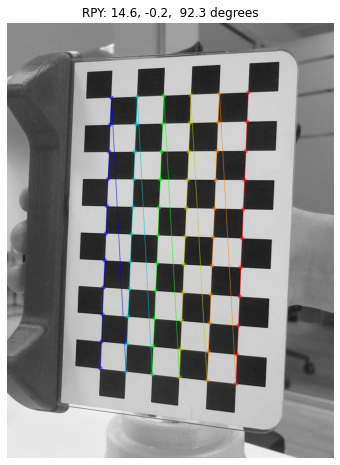

In [202]:
# R321
roll = atan2(R[2,1], R[2,2])*180/pi
pitch = -asin(R[2,0])*180/pi
yaw = atan2(R[1,0], R[0,0])*180/pi

plt.figure(figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.title(f"RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
plt.axis('off');

In [203]:
# def drawFrameAxes2(image, K, dist, rvecs, tvecs, length=None, thick=None):
#     rows,cols = image.shape[:2]
    
#     if length is None:
#         s = 0.3*np.min(image.shape[:2])
#     else:
#         s = length
        
#     print(f"scale: {s}")
    
#     axis = np.float32([[s,0,0], [0,s,0], [0,0,s]])
#     R = cv2.Rodrigues(rvecs)[0]
#     axis = K @ (R @ axis + tvecs)
#     print("axis", axis)
    
#     xx = (axis[:,0] / axis[2,0]).astype("int")[:2]
#     yy = (axis[:,1] / axis[2,1]).astype("int")[:2]
#     zz = (axis[:,2] / axis[2,2]).astype("int")[:2]
#     print(xx, yy, zz)
    
#     img = image.copy()
#     corner = (rows//2,cols//2,)
#     print(corner, yy)
    
#     img = cv2.line(img, corner, xx, (255,0,0), thick)
#     img = cv2.line(img, corner, yy, (0,255,0), thick)
#     img = cv2.line(img, corner, zz, (0,0,255), thick)
    
#     return img

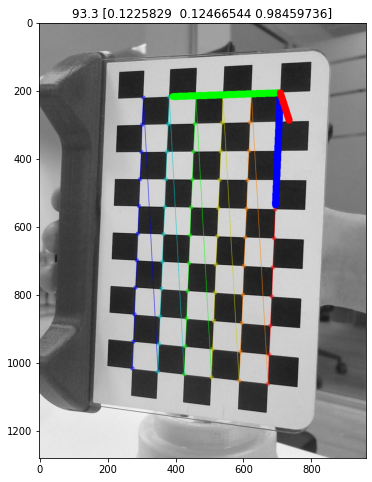

In [204]:
# set the axes size as a function of the marker's 
# square size and project onto image space
s = 4*square_width
axis = np.float32([[s,0,0], [0,s,0], [0,0,-s]]).reshape(-1,3)
imgpts, jac = cv2.projectPoints(
    axis, 
    rvecs, 
    tvecs, 
    camera_matrix, 
    distortion_coefficients
)

# print(imgpts)

# aimg = drawFrameAxes(image,corners.astype(int),imgpts.astype(int),thick=10)

aimg = image.copy()
aimg = cv2.drawFrameAxes(
    aimg, 
    camera_matrix, 
    distortion_coefficients, 
    rvecs, tvecs, 
    length=50, thickness=20) 

# aimg = drawFrameAxes2(
#     aimg, 
#     camera_matrix, 
#     distortion_coefficients, 
#     rvecs, tvecs, 
#     thick=10) 

# The x and y axes should lie on the surface of the image
# while the x axis is into the chessboard
plt.figure(figsize=(8,8))
plt.title(f"{theta*180/pi:.1f} {e}")
plt.imshow(aimg);

# References

- github: [3D Scan Science](https://github.com/Jesus89/3DScanScience)
- OpenCV Docs [pose](https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html)
- OpenCV Docs [solvePnP](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga549c2075fac14829ff4a58bc931c033d)
- wikipedia: [Rodriques rotations](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)
- wikipedia: [axis angle representation](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation)

# Appedix: Rodrigues to Rotation Matrix

The equation from above again is:

$$
R = I + (sin \theta) K + (1-cos \theta) K^2
$$

In [127]:
def skew(x):
    return np.array([
        [0.0, -x[2], x[1]],
        [x[2], 0.0, -x[0]],
        [-x[1], x[0], 0.0]
    ])

rr, _ = cv2.Rodrigues(rvecs)
print("cv2.Rodrigues:\n", rr, "\n\n")

r = rvecs.ravel()
theta = norm(r)
e = r/theta
k = skew(e)
rot = np.eye(3) + sin(theta) * k + (1-cos(theta)) * k@k
print("wikipedia:\n", rot)

cv2.Rodrigues:
 [[-0.04080699 -0.96674275  0.25247425]
 [ 0.99916456 -0.0400462   0.00815342]
 [ 0.00222838  0.25259604  0.96756926]] 


wikipedia:
 [[-0.04080699 -0.96674275  0.25247425]
 [ 0.99916456 -0.0400462   0.00815342]
 [ 0.00222838  0.25259604  0.96756926]]


# Appendix B: `cv2.drawFrameAxes` Broken

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


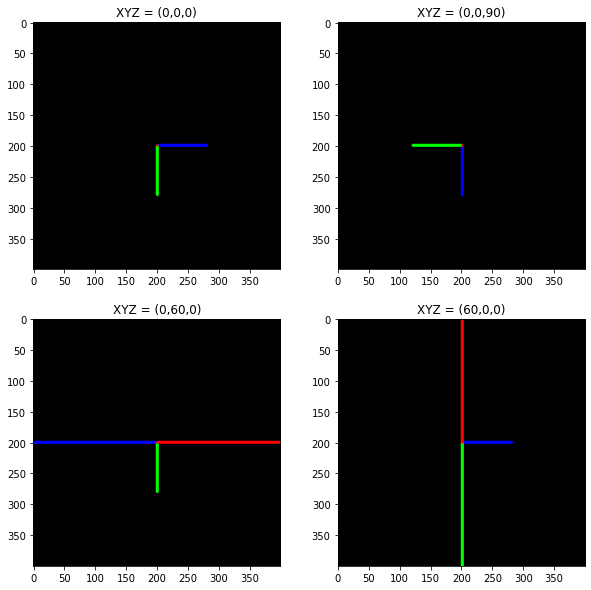

In [98]:
def drawAxes(rvecs):
    tvecs = np.array([0,0,0.])
    width = 400

    im = np.zeros((width,width,3))
    cx, cy = width//2, width//2
    f = width
    K = np.array([[f, 0, cx],[0, f, cy],[0, 0, 1]], dtype=float)
    dist = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)

    # set the axes size as a function of the marker's 
    # square size and project onto image space
    s = 4
    axis = np.float32([[s,0,0], [0,s,0], [0,0,s]]).reshape(-1,3)
    imgpts, jac = cv2.projectPoints(
        axis, 
        rvecs, 
        tvecs, 
        K, 
        dist
    )

    cv2.drawFrameAxes(
        im, 
        K, 
        dist, 
        rvecs, tvecs, 
        length=.2, thickness=3) 
    
    return im

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(drawAxes(np.array([0,0,0.])))
plt.title("XYZ = (0,0,0)");

# should rotate around blue axis, but rotates around red ... wtf???
plt.subplot(2,2,2)
plt.imshow(drawAxes(np.array([0,0,pi/2])))
plt.title("XYZ = (0,0,90)");

# looks correct, rotates around green axis
plt.subplot(2,2,3)
plt.imshow(drawAxes(np.array([0,pi/3,0])))
plt.title("XYZ = (0,60,0)");

# should rotate around red axis, but rotates around blue ... wtf???
plt.subplot(2,2,4)
plt.imshow(drawAxes(np.array([pi/3,0,0])))
plt.title("XYZ = (60,0,0)");